Load required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

plt.style.use('seaborn-white')
%matplotlib inline

/Users/winston/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Some plotting functions to help you plot the ROC curve

In [2]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


Load the Sacramento housing data

In [5]:
sac = pd.read_csv('../assets/datasets/Sacramentorealestatetransactions.csv')

Create a binary variable where 1 indicates a house sold for over 200,000 and 0 indicates a house sold for equal to or less than 200,000.

Subset the data to just contain the number of beds, baths, the sq ft, and the over 200k indicator variable.

In [6]:
sac['over_200k'] = sac['price'].map(lambda x: 0 if x > 200000 else 1)
sac = sac[['beds','baths','sq__ft','over_200k']]
sac.dropna(inplace=True)

In [7]:
print sac.head()
print sac.shape
print np.sum(sac.over_200k)

   beds  baths  sq__ft  over_200k
0     2      1     836          1
1     3      1    1167          1
2     2      1     796          1
3     2      1     852          1
4     2      1     797          1
(985, 4)
447


Split your data into training and testing sets. The predictors are the beds, baths, and sq ft. The feature is the over 200k class variable. Make the test size 33% (and optionally stratify by the over 200k class).

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(sac[['beds','baths','sq__ft']].values,
                                                    sac.over_200k.values, 
                                                    test_size=0.33, stratify=sac.over_200k.values,
                                                    random_state=77)

Fit a logistic regression on the training data.

In [9]:
logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

Print out the confusion matrix

In [10]:
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['over_200k', 'under_200k'],
                         columns=['predicted_over_200k','predicted_under_200k'])

print(confusion)

            predicted_over_200k  predicted_under_200k
over_200k                    69                    79
under_200k                   51                   127


Calculate the accuracy, precision, and recall. What can these three metrics tell you about your model?

In [11]:
# Accuracy tells us the percent of houses selling for over and under 200k correctly predicted
print(accuracy_score(Y_test, Y_pred))

# Precision tells us how well the classifier avoided misclassifying the over 200k houses
print(precision_score(Y_test, Y_pred))

# Recall tells us how well the classifier correctly identified houses as selling for over 200k
print(recall_score(Y_test, Y_pred))

# The difference between precision and recall can be tricky to interpret. The intuition here is
# that precision is a measure of the QUALITY of results: of the houses labeled as over 200k,
# how many of those were correct?
# Recall, on the other hand, is a measure of the COMPLETENESS of results: of all the houses
# that sold for over 200k, how many were identified by the classifier?
# On the flip side, you can have a high precision but identify very few of the total 200k houses.
# Likewise, you can have a high recall but also incorrectly identify many under 200k houses
# as over 200k houses.

0.601226993865
0.575
0.466216216216


Say as a real estate agent, I prioritize minimizing false positives (predicting a house will sell for over 200k when it actually sells for under) because false positives make me lose money.

Change the decision threshold to **lower the false positive rate** and then print out the new confusion matrix. What is the downside to lowering the false positive rate?

In [12]:
Y_pp = pd.DataFrame(logreg.predict_proba(X_test), columns=['under_200k_pp','over_200k_pp'])

# change the threshold to predict over 200k to 0.7 - it is harder for the classifier to assign the over 200k label
Y_pp['over_200k_high_thresh'] = [1 if x >= 0.70 else 0 for x in Y_pp.over_200k_pp.values]

conmat_high = np.array(confusion_matrix(Y_test, Y_pp.over_200k_high_thresh.values, labels=[1,0]))

confusion_high = pd.DataFrame(conmat_high, index=['over_200k', 'under_200k'],
                              columns=['predicted_over_200k','predicted_under_200k'])

print(confusion_high)

# The downside to lowering the false positive rate is that the false negative rate increases.

            predicted_over_200k  predicted_under_200k
over_200k                    15                   133
under_200k                   18                   160


Plot the ROC curve using the plotting function provided.

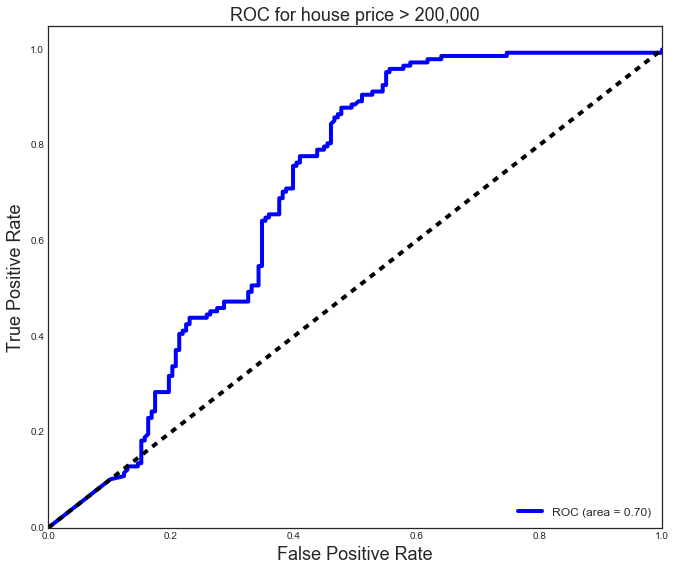

In [13]:
Y_score = logreg.decision_function(X_test)
plot_roc(Y_test, Y_score)

Bonus: when might precision and recall be more useful than the ROC?

Precision and recall are more useful when the proportion of the positive class is smaller, since they are sensitive to this.